In [1]:
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/home/Yan-Cheng-Hsu/anaconda3/envs/test/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model , Sequential
from keras.layers import Input, LSTM , Bidirectional , Dropout , Activation , Dense , Add , GRU , concatenate
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
from keras.models import load_model , save_model
import os
from scipy.stats import pearsonr

os.environ["CUDA_VISIBLE_DEVICES"] = ' 2 '

def rmse_loss (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

def mae_loss (y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))
    
lambda_mse = 10 # hyperparameter to be adjusted

def joint_loss (y_true, y_pred):
    rmse_loss = K.sqrt(K.mean(K.square(y_true - y_pred)))
    mae_loss = K.mean(K.abs(y_true - y_pred))
    
    return mae_loss + (lambda_mse * rmse_loss)



print('feature loading......')
features = np.load( '/data1/Yan-Cheng-Hsu/TimeSeriesFeatures/TDFE_20200601/TDFE_20200601_32i_Features.npy' , allow_pickle = True )
bp = np.load( '/data1/Yan-Cheng-Hsu/TimeSeriesFeatures/TDFE_20200601/TDFE_20200601_32i_BP.npy' , allow_pickle = True )


print( 'feature loading finished.' )




print( 'Preprocessing......' )

RawFeatures = []
RawBP = []
Features = []
BP = []
maxList = []
minList = []
avgList = []

for x in range( len(bp) ):
    zerol = []
    for i in range( len(bp[x]) ):
        if bp[x][i][1] == 0:
            zerol.append( i )
            
    if len(zerol) != 0 :  
        
        if ( zerol[0] == 0 ) and ( zerol[ len(zerol)-1 ] == ( len(bp[x])-1 ) ) :
            for i in range( 1 , len(zerol) , 1 ):
                tempf = features[x][ (zerol[i-1]+1) : zerol[i] ]
                tempb = bp[x][ (zerol[i-1]+1) : zerol[i] ]
                if( len(tempb) != 0 ):
                    RawFeatures.append( tempf )
                    RawBP.append( tempb )
        elif ( zerol[0] == 0 ) and ( zerol[ len(zerol)-1 ] != ( len(bp[x])-1 ) ) :
            for i in range( 1 , len(zerol) , 1 ):
                tempf = features[x][ (zerol[i-1]+1) : zerol[i] ]
                tempb = bp[x][ (zerol[i-1]+1) : zerol[i] ]
                if( len(tempb) != 0 ):
                    RawFeatures.append( tempf )
                    RawBP.append( tempb )
            tempf = features[x][ (zerol[len(zerol)-1])+1 : len(features[x])-1 ]
            tempb = bp[x][ (zerol[len(zerol)-1])+1 : len(bp[x])-1 ]
            if( len(tempb) != 0 ):
                RawFeatures.append( tempf )
                RawBP.append( tempb )
        elif ( zerol[0] != 0 ) and ( zerol[ len(zerol)-1 ] == ( len(bp[x])-1 ) ) :
            tempf = features[x][ 0 : zerol[0] ]
            tempb = bp[x][ 0 : zerol[0] ]
            if( len(tempb) != 0 ) :
                RawFeatures.append( tempf )
                RawBP.append( tempb )
            for i in range( 1 , len(zerol) , 1 ):
                tempf = features[x][ (zerol[i-1]+1) : zerol[i] ]
                tempb = bp[x][ (zerol[i-1]+1) : zerol[i] ]
                if( len(tempb) != 0 ) :
                    RawFeatures.append( tempf )
                    RawBP.append( tempb )
        else :
            tempf = features[x][ 0 : zerol[0] ]
            tempb = bp[x][ 0 : zerol[0] ]
            if( len(tempb) != 0 ):
                RawFeatures.append( tempf )
                RawBP.append( tempb )
            for i in range( 1 , len(zerol) , 1 ):
                tempf = features[x][ (zerol[i-1]+1) : zerol[i] ]
                tempb = bp[x][ (zerol[i-1]+1) : zerol[i] ]
                if( len(tempb) != 0 ) :
                    RawFeatures.append( tempf )
                    RawBP.append( tempb )
            tempf = features[x][ (zerol[len(zerol)-1])+1 : len(features[x])-1 ]
            tempb = bp[x][ (zerol[len(zerol)-1])+1 : len(bp[x])-1 ]
            if( len(tempb) != 0 ) :
                RawFeatures.append( tempf )
                RawBP.append( tempb )     
    else :
        if( len(bp[x]) != 0 ):
            RawFeatures.append( features[x] )
            RawBP.append( bp[x] )



for i in range( len(RawFeatures) ):

    if len(RawFeatures[i]) < 1:
        continue
    else:
        for j in range( 1 , len(RawFeatures[i]) , 1 ):
            Features.append( RawFeatures[i][j-1:j] )
            BP.append( RawBP[i][j-1:j] )
Features = np.array( Features )
BP = np.array( BP )


for i in range( len(Features) ):
    maxList.append( np.max( Features[i] , axis = 0 ) )
    minList.append( np.min( Features[i] , axis = 0 ) )
    avgList.append( np.mean( Features[i] , axis = 0 ) )
    

maxList = np.array( maxList )
minList = np.array( minList )
avgList = np.array( avgList )
    
maxArray = np.max( maxList , axis = 0 )
minArray = np.min( minList , axis = 0 )
avgArray = np.mean( avgList , axis = 0 )

for i in range( len(Features) ):
    Features[i] = ( Features[i] - avgArray ) / ( maxArray - minArray )


x_train , x_test , y_train , y_test = train_test_split( Features , BP , test_size = 0.2 )


X_train = np.ndarray( ( len(x_train) , 1 , 32 ), dtype=float)
for i in range( len(x_train) ):
    X_train[i] = x_train[i]
X_test = np.ndarray( ( len(x_test) , 1 , 32 ), dtype=float)
for i in range( len(x_test) ):
    X_test[i] = x_test[i]
Y_train = np.ndarray( ( len(y_train) , 1 , 2 ), dtype=float)
for i in range( len(y_train) ):
    Y_train[i] = y_train[i]
Y_test = np.ndarray( ( len(y_test) , 1 , 2 ), dtype=float)
for i in range( len(y_test) ):
    Y_test[i] = y_test[i]




print( 'Preprocessing finished.' )

Using TensorFlow backend.


feature loading......
feature loading finished.
Preprocessing......
Preprocessing finished.


In [3]:
model_path = '/home/Yan-Cheng-Hsu/PaperPublication/best.h5'
loadModel = load_model( model_path , custom_objects = { 'rmse_loss' : rmse_loss , 'joint_loss' : joint_loss , 'mae_loss' : mae_loss })
loadModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 32)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 2048)           67584     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2048)           0         
_________________________________________________________________
activation_1 (Activation)    (None, 1, 2048)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 4096)           8392704   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 4096)           0         
_________________________________________________________________
activation_2 (Activation)    (None, 1, 4096)           0   

In [4]:
f = np.ndarray( (X_train.shape[0]+X_test.shape[0] , 1 , 32) , dtype = float )
bp = np.ndarray( (Y_train.shape[0]+Y_test.shape[0] , 1 , 2) , dtype = float )
for i in range( X_train.shape[0] ):
    f[i] = X_train[i]
for i in range( X_test.shape[0] ):
    f[i+X_train.shape[0]] = X_test[i]

for i in range( Y_train.shape[0] ):
    bp[i] = Y_train[i]
for i in range( Y_test.shape[0] ):
    bp[i+Y_train.shape[0]] = Y_test[i]
print( loadModel.evaluate( f , bp ) )

2176188/2176188 [==============================] - 152s 70us/step
[42.1701312353367, 3.944736957550049, 2.7227773666381836]


In [5]:
a = loadModel.predict( f )
e_sbp = []
e_dbp = []
t_sbp = []
t_dbp = []
for i in range( len(a) ):
    e_sbp.append( a[i][0][0] )
    e_dbp.append( a[i][0][1] )
    t_sbp.append( bp[i][0][0] )
    t_dbp.append( bp[i][0][1] )

Pearson's Correlation, r =  0.9471896399301747


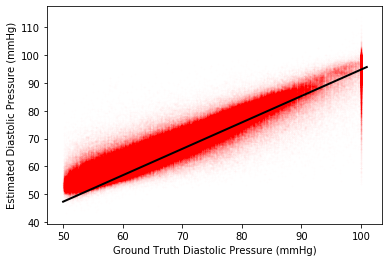

In [21]:
x = np.linspace( 50 , 101 , 52 )
r = pearsonr( t_dbp , e_dbp )
print( "Pearson's Correlation, r = " , r[0] )
plt.plot( x , x*r[0] , color = 'black' , linewidth = 2 )#label = "Pearson's correlation r = " + str( round( r[0] , 6 ) ) )
plt.scatter( t_dbp , e_dbp , color = 'red' , marker = 'o' , alpha = 1/255 , s = 2 )
plt.xlabel( 'Ground Truth Diastolic Pressure (mmHg)' )
plt.ylabel( 'Estimated Diastolic Pressure (mmHg)' )
#plt.title( 'Regression Plot of DBP , Number of Samples = ' + str(bp.shape[0]) )
#plt.savefig( '/home/Yan-Cheng-Hsu/PaperPublication/dbp_regression_plot.png' )
#plt.legend( loc = 'best' )
plt.show()

Pearson's Correlation, r =  0.9770329540639578


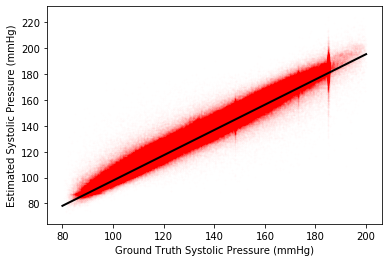

In [22]:
x = np.linspace( 80 , 200 , 200 )
r = pearsonr( t_sbp , e_sbp )
print( "Pearson's Correlation, r = " , r[0] )
plt.plot( x , x*r[0] , color = 'black' , linewidth = 2 ) #label = "Pearson's correlation r = " + str( round( r[0] , 6 ) ) )
plt.scatter( t_sbp , e_sbp , color = 'red' , marker = 'o' , alpha = 1/255 , s = 2 )
plt.xlabel( 'Ground Truth Systolic Pressure (mmHg)' )
plt.ylabel( 'Estimated Systolic Pressure (mmHg)' )
#plt.title( 'Regression Plot of DBP , Number of Samples =' + str(bp.shape[0]) )
#plt.savefig( '/home/Yan-Cheng-Hsu/PaperPublication/sbp_regression_plot.png' )
#plt.legend( loc = 'best' )
plt.show()

In [8]:
t_sbp = np.array( t_sbp )
e_sbp = np.array( e_sbp )
t_dbp = np.array( t_dbp )
e_dbp = np.array( e_dbp )
#err_sbp = np.sort( np.around( t_sbp - e_sbp , 0) , kind = 'heapsort' )
#err_dbp = np.sort( np.around( t_dbp - e_dbp , 0) , kind = 'heapsort' )
err_sbp = t_sbp - e_sbp
err_dbp = t_dbp - e_dbp

x = {}
y = {}
x['SBP'] = [i for i in range( -80 , 86 ,1)]
x['DBP'] = [i for i in range( -35 , 51 ,1)]
y['SBP'] = err_sbp
y['DBP'] = err_dbp

SBP:
Mean of Error =  -0.30964357041557894
Std of Error =  4.632628174722503
Max of Error =  83.19867382061523
Min of Error =  -76.3774746496207


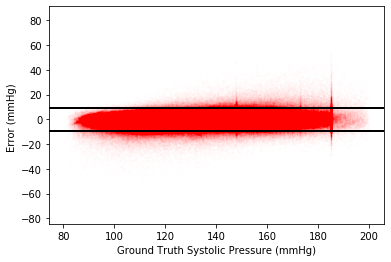

DBP:
Mean of Error =  0.4492006879300865
Std of Error =  3.2765907578948927
Max of Error =  46.47109603881836
Min of Error =  -34.56241971667729


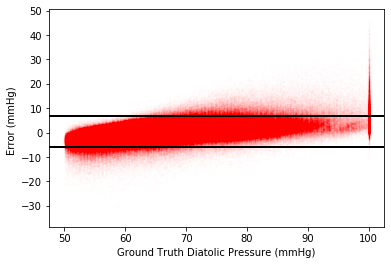

In [9]:
m = [ 'SBP' , 'DBP' ]
for i in m:
    if i == 'SBP':
        print('SBP:')
        print( 'Mean of Error = ' , np.mean( err_sbp ) )
        print( 'Std of Error = ' , np.std( err_sbp ) )
        print( 'Max of Error = ' , np.max( err_sbp ) )
        print( 'Min of Error = ' , np.min( err_sbp ) )
        plt.scatter( t_sbp , err_sbp , color = 'red' , marker = 'o' , alpha = 1/255 , s = 2 )
        plt.xlabel( 'Ground Truth Systolic Pressure (mmHg)' )
        plt.ylabel( 'Error (mmHg) ' )
        plt.axhline( np.mean( err_sbp ) + 2*np.std( err_sbp ) , color = 'black' , linewidth = 2 )
        plt.axhline( np.mean( err_sbp ) - 2*np.std( err_sbp ) , color = 'black' , linewidth = 2 )
        plt.show()
    else:
        print('DBP:')
        print( 'Mean of Error = ' , np.mean( err_dbp ) )
        print( 'Std of Error = ' , np.std( err_dbp ) )
        print( 'Max of Error = ' , np.max( err_dbp ) )
        print( 'Min of Error = ' , np.min( err_dbp ) )
        plt.scatter( t_dbp , err_dbp , color = 'red' , marker = 'o' , alpha = 1/255 , s = 2 )
        plt.xlabel( 'Ground Truth Diatolic Pressure (mmHg)' )
        plt.ylabel( 'Error (mmHg) ' )
        plt.axhline( np.mean( err_dbp ) + 2*np.std( err_dbp ) , color = 'black' , linewidth = 2 )
        plt.axhline( np.mean( err_dbp ) - 2*np.std( err_dbp ) , color = 'black' , linewidth = 2 )
        plt.show()

In [29]:
Att = {}
Att['SBP'] = err_sbp
Att['DBP'] = err_dbp
x = {}
x['SBP'] = [i for i in range( -80 , 86 ,1)]
x['DBP'] = [i for i in range( -35 , 51 ,1)]

SBP  : 
RMSE =  4.642964887432646
MAE =  3.2139456522383423
Mean =  -0.30964357041557894
std =  4.632628174722503
Absolute Error < 5 mmHg : 1754772 , 80.63512895025615  %
Absolute Error < 10 mmHg : 2086172 , 95.86359266754528  %
Absolute Error < 15 mmHg : 2149675 , 98.78167695070462  %


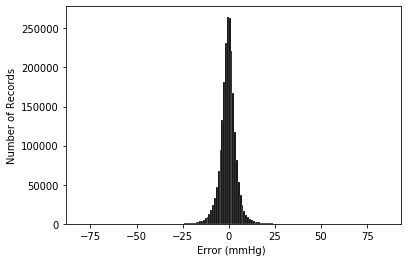

DBP  : 
RMSE =  3.3072387656108364
MAE =  2.2316207839773385
Mean =  0.4492006879300865
std =  3.2765907578948927
Absolute Error < 5 mmHg : 1962761 , 90.19262122573969  %
Absolute Error < 10 mmHg : 2139095 , 98.295505719175  %
Absolute Error < 15 mmHg : 2167343 , 99.59355533621176  %


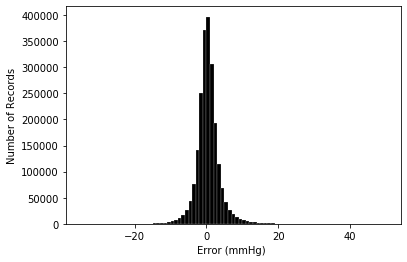

In [32]:
import math
for i in m: 
    print( i  , ' : ')
    print( 'RMSE = ' , math.sqrt( np.mean( np.power( Att[i] , 2 ) ) ) )
    print( 'MAE = ' , np.mean( np.abs( Att[i] ) ) )
    print( 'Mean = ' , np.mean( Att[i] ) )
    print( 'std = ' , np.std( Att[i] ) )
    
    counter = 0
    counter1 = 0
    counter2 = 0
    for j in range( len(y[i]) ):
        if np.abs( y[i][j] ) < 5 :
            counter = counter + 1
        if np.abs( y[i][j] ) < 10 :
            counter1 = counter1 + 1
        if np.abs( y[i][j] ) < 15 :
            counter2 = counter2 + 1
    
    print( 'Absolute Error < 5 mmHg :' , counter , ',' , counter/len(y[i])*100 , ' %'  )
    print( 'Absolute Error < 10 mmHg :' , counter1 , ',' , counter1/len(y[i])*100 , ' %'  )
    print( 'Absolute Error < 15 mmHg :' , counter2 , ',' , counter2/len(y[i])*100 , ' %'  )    
    plt.hist(  y[i] , bins = x[i] , color = 'black' , width = 1 , edgecolor = 'white' , lw = 0.2 )
    plt.xlabel( 'Error (mmHg) ' )
    plt.ylabel( 'Number of Records' )
    #plt.legend( loc = 'best' )
    plt.show() 

SBP  : 
RMSE =  4.642964887432646
MAE =  3.2139456522383423
Mean =  -0.30964357041557894
std =  4.632628174722503
Absolute Error < 5 mmHg : 1754772 , 80.63512895025615  %
Absolute Error < 10 mmHg : 2086172 , 95.86359266754528  %
Absolute Error < 15 mmHg : 2149675 , 98.78167695070462  %


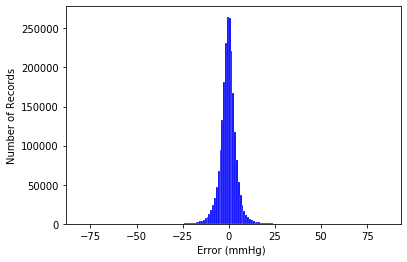

DBP  : 
RMSE =  3.3072387656108364
MAE =  2.2316207839773385
Mean =  0.4492006879300865
std =  3.2765907578948927
Absolute Error < 5 mmHg : 1962761 , 90.19262122573969  %
Absolute Error < 10 mmHg : 2139095 , 98.295505719175  %
Absolute Error < 15 mmHg : 2167343 , 99.59355533621176  %


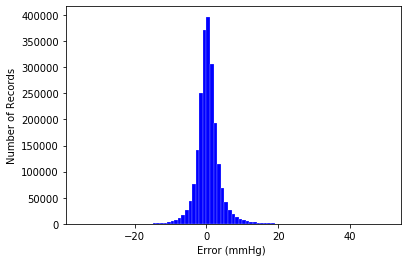

In [33]:
import math
for i in m: 
    print( i  , ' : ')
    print( 'RMSE = ' , math.sqrt( np.mean( np.power( Att[i] , 2 ) ) ) )
    print( 'MAE = ' , np.mean( np.abs( Att[i] ) ) )
    print( 'Mean = ' , np.mean( Att[i] ) )
    print( 'std = ' , np.std( Att[i] ) )
    
    counter = 0
    counter1 = 0
    counter2 = 0
    for j in range( len(y[i]) ):
        if np.abs( y[i][j] ) < 5 :
            counter = counter + 1
        if np.abs( y[i][j] ) < 10 :
            counter1 = counter1 + 1
        if np.abs( y[i][j] ) < 15 :
            counter2 = counter2 + 1
    
    print( 'Absolute Error < 5 mmHg :' , counter , ',' , counter/len(y[i])*100 , ' %'  )
    print( 'Absolute Error < 10 mmHg :' , counter1 , ',' , counter1/len(y[i])*100 , ' %'  )
    print( 'Absolute Error < 15 mmHg :' , counter2 , ',' , counter2/len(y[i])*100 , ' %'  )    
    plt.hist(  y[i] , bins = x[i] , color = 'blue' , width = 1 , edgecolor = 'white' , lw = 0.2 )
    plt.xlabel( 'Error (mmHg) ' )
    plt.ylabel( 'Number of Records' )
    plt.show() 